# Exploratory Data Analysis (EDA) for Septicemia Risk Prediction

This notebook performs EDA on the CMS SynPUF dataset to inform feature engineering for the septicemia risk prediction pipeline. Objectives:
- Analyze beneficiary demographics (age, sex, chronic conditions).
- Identify top ICD-9 and HCPCS codes in claims data.
- Examine claim counts and payment amounts by file type (inpatient, outpatient, carrier).
- Generate visualizations and save results to `data/processed/septicemia_risk/eda/`.

## Setup
Use Dask for scalability, PyArrow for efficient CSV reading, and logging to track progress.

In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import os
from pathlib import Path
import sys

# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utils import setup_logger

# Initialize logger
logger = setup_logger(log_dir=os.path.join(project_root, 'outputs/logs'), log_file='eda.log')
logger.info('Starting EDA notebook')

# Set output directory
output_dir = os.path.join(project_root, 'data/processed/septicemia_risk/eda')
os.makedirs(output_dir, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8-notebook')
%matplotlib inline

SynPUFPipeline - INFO - Starting EDA notebook


## Load Data
Load beneficiary and claims data using Dask with PyArrow backend.

In [6]:
# Define dtypes
BENEFICIARY_DTYPES = {
    'DESYNPUF_ID': str,
    'BENE_BIRTH_DT': str,
    'BENE_SEX_IDENT_CD': str,
    'SP_STATE_CODE': str,
    'BENE_HI_CVRAGE_TOT_MONS': 'int32',
    'SP_ALZHDMTA': 'int8',
    'SP_CHF': 'int8',
    'SP_CHRNKIDN': 'int8',
    'SP_CNCR': 'int8',
    'SP_COPD': 'int8',
    'SP_DEPRESSN': 'int8',
    'SP_DIABETES': 'int8',
    'SP_ISCHMCHT': 'int8',
    'SP_OSTEOPRS': 'int8',
    'SP_RA_OA': 'int8',
    'SP_STRKETIA': 'int8'
}

CLAIMS_DTYPES = {
    'DESYNPUF_ID': str,
    'CLM_ID': str,
    'CLM_FROM_DT': str,
    'CLM_PMT_AMT': 'float64',
    'ADMTNG_ICD9_DGNS_CD': str,
    **{f'ICD9_DGNS_CD_{i}': str for i in range(1, 11)},
    **{f'HCPCS_CD_{i}': str for i in range(1, 46)},
    **{f'LINE_ICD9_DGNS_CD_{i}': str for i in range(1, 14)},
    **{f'LINE_NCH_PMT_AMT_{i}': 'float64' for i in range(1, 14)}
}

# Load beneficiary data
beneficiary_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2009_Beneficiary_Summary_File_Sample_1.csv'),
    usecols=list(BENEFICIARY_DTYPES.keys()),
    dtype=BENEFICIARY_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
beneficiary_df['age'] = 2009 - dd.to_datetime(beneficiary_df['BENE_BIRTH_DT'], format='%Y%m%d').dt.year
beneficiary_df['age'] = beneficiary_df['age'].fillna(0).astype('int32')
chronic_cols = ['SP_ALZHDMTA', 'SP_CHF', 'SP_CHRNKIDN', 'SP_CNCR', 'SP_COPD',
                'SP_DEPRESSN', 'SP_DIABETES', 'SP_ISCHMCHT', 'SP_OSTEOPRS',
                'SP_RA_OA', 'SP_STRKETIA']
for col in chronic_cols:
    beneficiary_df[col] = (beneficiary_df[col] == 1).astype('int8')
beneficiary_df['chronic_condition_count'] = beneficiary_df[chronic_cols].sum(axis=1).fillna(0).astype('int32')
logger.info(f'Beneficiary data loaded: {len(beneficiary_df)} rows')
logger.info(f'Beneficiary null counts: {beneficiary_df.isna().sum().compute()}')

# Load claims data
inpatient_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Inpatient_Claims_Sample_1.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_PMT_AMT', 'ADMTNG_ICD9_DGNS_CD'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 46)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
outpatient_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Outpatient_Claims_Sample_1.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT', 'CLM_PMT_AMT', 'ADMTNG_ICD9_DGNS_CD'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 11)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 46)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)
carrier_df = dd.read_csv(
    os.path.join(project_root, 'data/raw/DE1_0_2008_to_2010_Carrier_Claims_Sample_1A.csv'),
    usecols=['DESYNPUF_ID', 'CLM_ID', 'CLM_FROM_DT'] + 
            [f'ICD9_DGNS_CD_{i}' for i in range(1, 9)] + 
            [f'LINE_ICD9_DGNS_CD_{i}' for i in range(1, 14)] + 
            [f'HCPCS_CD_{i}' for i in range(1, 13)] + 
            [f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)],
    dtype=CLAIMS_DTYPES,
    blocksize=10e6,
    engine='pyarrow'
)

# Clean claims data
for df, file_type in [(inpatient_df, 'inpatient'), (outpatient_df, 'outpatient'), (carrier_df, 'carrier')]:
    df['CLM_FROM_DT'] = df['CLM_FROM_DT'].str.replace(r'\.0$', '', regex=True).str.strip()
    df['CLM_FROM_DT'] = dd.to_datetime(df['CLM_FROM_DT'], format='%Y%m%d', errors='coerce')
    df = df[~df['CLM_FROM_DT'].isna()].persist()
    icd9_cols = [col for col in df.columns if 'ICD9_DGNS_CD' in col or 'LINE_ICD9_DGNS_CD' in col]
    for col in icd9_cols:
        df[col] = df[col].str.strip().replace('', np.nan).fillna('').astype('string')
    hcpcs_cols = [col for col in df.columns if 'HCPCS_CD' in col]
    for col in hcpcs_cols:
        df[col] = df[col].str.strip().replace('', np.nan).fillna('').astype('string')
    logger.info(f'{file_type}_df null counts: {df.isna().sum().compute()}')

# Sum LINE_NCH_PMT_AMT for carrier claims
carrier_df['CLM_PMT_AMT'] = carrier_df[[f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)]].fillna(0).sum(axis=1).astype('float64')
carrier_df = carrier_df.drop(columns=[f'LINE_NCH_PMT_AMT_{i}' for i in range(1, 14)])

# Combine claims
inpatient_df['file_type'] = 'inpatient'
outpatient_df['file_type'] = 'outpatient'
carrier_df['file_type'] = 'carrier'
claims_df = dd.concat([inpatient_df, outpatient_df, carrier_df], axis=0).persist()
logger.info(f'Combined claims_df: {len(claims_df)} rows')
logger.info(f'claims_df null counts: {claims_df.isna().sum().compute()}')

SynPUFPipeline - INFO - Beneficiary data loaded: 114538 rows
SynPUFPipeline - INFO - Beneficiary null counts: DESYNPUF_ID                0
BENE_BIRTH_DT              0
BENE_SEX_IDENT_CD          0
SP_STATE_CODE              0
BENE_HI_CVRAGE_TOT_MONS    0
SP_ALZHDMTA                0
SP_CHF                     0
SP_CHRNKIDN                0
SP_CNCR                    0
SP_COPD                    0
SP_DEPRESSN                0
SP_DIABETES                0
SP_ISCHMCHT                0
SP_OSTEOPRS                0
SP_RA_OA                   0
SP_STRKETIA                0
age                        0
chronic_condition_count    0
dtype: int64
SynPUFPipeline - INFO - inpatient_df null counts: DESYNPUF_ID            0
CLM_ID                 0
CLM_FROM_DT            0
CLM_PMT_AMT            0
ADMTNG_ICD9_DGNS_CD    0
ICD9_DGNS_CD_1         0
ICD9_DGNS_CD_2         0
ICD9_DGNS_CD_3         0
ICD9_DGNS_CD_4         0
ICD9_DGNS_CD_5         0
ICD9_DGNS_CD_6         0
ICD9_DGNS_CD_7         0
ICD9_

In [100]:
claims_df.head()

,DESYNPUF_ID,CLM_ID,CLM_FROM_DT,CLM_PMT_AMT,ADMTNG_ICD9_DGNS_CD,ICD9_DGNS_CD_1,ICD9_DGNS_CD_2,ICD9_DGNS_CD_3,ICD9_DGNS_CD_4,ICD9_DGNS_CD_5,...,LINE_ICD9_DGNS_CD_6,LINE_ICD9_DGNS_CD_7,LINE_ICD9_DGNS_CD_8,LINE_ICD9_DGNS_CD_9,LINE_ICD9_DGNS_CD_10,LINE_ICD9_DGNS_CD_11,LINE_ICD9_DGNS_CD_12,LINE_ICD9_DGNS_CD_13,septicemia_case_ind,index_date
0,00013D2EFD8E45D1,196661176988405,2010-03-12,4000.0,4580,7802,78820,V4501,4280,2720,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-10-14
1,00016F745862898F,196201177000368,2009-04-12,26000.0,7866,1970,4019,5853,7843,2768,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
2,00016F745862898F,196661177015632,2009-08-31,5000.0,6186,6186,2948,56400,None,None,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
3,00016F745862898F,196091176981058,2009-09-17,5000.0,29590,29623,30390,71690,34590,V1581,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16
4,00016F745862898F,196261176983265,2010-06-26,16000.0,5849,3569,4019,3542,V8801,78820,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,0.0,2009-05-16


## Index Dates
Load datasets with index dates for septicemia cases and outcome status. 

In [9]:
cases_df = pd.read_csv(os.path.join(project_root, 'data/processed/septicemia_risk/septicemia_cases.csv'))
cases_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1073 entries, 0 to 1072
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DESYNPUF_ID             1073 non-null   object
 1   latest_septicemia_date  1073 non-null   object
dtypes: object(2)
memory usage: 16.9+ KB


In [35]:
def assign_index_dates(septicemia_cases: pd.DataFrame, claims_df: dd.DataFrame,
                      beneficiary_df: dd.DataFrame, start_date: str = '2009-01-01',
                      end_date: str = '2009-12-25') -> dd.DataFrame:
    """
    Assign index dates: latest septicemia date or random 2009 claim date.
    
    Args:
        septicemia_cases (dd.DataFrame): Beneficiaries with septicemia.
        claims_df (dd.DataFrame): Combined claims data.
        beneficiary_df (dd.DataFrame): Beneficiary data.
        start_date (str): Start date for random index (default: 2009-01-01).
        end_date (str): End date for random index (default: 2009-12-25).
    
    Returns:
        dd.DataFrame: DESYNPUF_ID and index_date.
    """
    logger.info("Assigning index dates")
    
    # Filter 2009 claims
    claims_2009 = claims_df[claims_df['CLM_FROM_DT'].dt.year == 2009][['DESYNPUF_ID', 'CLM_FROM_DT']]
    
    # Merge beneficiaries with claims to ensure coverage
    valid_beneficiaries = beneficiary_df[['DESYNPUF_ID']].merge(
        claims_2009[['DESYNPUF_ID']].drop_duplicates(), on='DESYNPUF_ID', how='inner'
    )
    
    # Assign latest septicemia date for septicemia cases
    septicemia_index = septicemia_cases.rename(columns={'latest_septicemia_date': 'index_date'})
    septicemia_index['septicemia_case_ind'] = 1
    
    # For non-septicemia beneficiaries, sample random 2009 claim date
    non_septicemia = valid_beneficiaries[~valid_beneficiaries['DESYNPUF_ID'].isin(septicemia_cases['DESYNPUF_ID'])]
    non_septicemia = non_septicemia.merge(claims_2009, on='DESYNPUF_ID')
    non_septicemia = non_septicemia[
        (non_septicemia['CLM_FROM_DT'] >= start_date) &
        (non_septicemia['CLM_FROM_DT'] <= end_date)
    ]
    
    # Randomly sample one date per beneficiary
    non_septicemia_index = non_septicemia.groupby('DESYNPUF_ID').apply(
        lambda x: x.sample(n=1, random_state=42)[['CLM_FROM_DT']],
        meta={'CLM_FROM_DT': 'datetime64[ns]'},
        include_groups=True
    ).reset_index().rename(columns={'index':'DESYNPUF_ID','CLM_FROM_DT': 'index_date'})[['DESYNPUF_ID', 'index_date']]
    non_septicemia_index['septicemia_case_ind'] = 0 # Add case indicators
    
    # Combine septicemia and non-septicemia index dates
    index_dates = dd.concat([septicemia_index, non_septicemia_index], axis=0)[['DESYNPUF_ID', 'septicemia_case_ind', 'index_date']]
    
    # # Save intermediate result
    # output_path = os.path.join(project_root, 'data/processed/septicemia_risk/index_dates.csv')
    # index_dates.to_csv(output_path, single_file=True, index=False)
    # logger.info(f"Assigned index dates for {len(index_dates)} beneficiaries, saved to {output_path}")
    
    return index_dates.compute()

In [36]:
index_dates = assign_index_dates(cases_df,claims_df,beneficiary_df)
index_dates.info()

SynPUFPipeline - INFO - Assigning index dates


<class 'pandas.core.frame.DataFrame'>
Index: 83012 entries, 0 to 555
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   DESYNPUF_ID          83012 non-null  object
 1   septicemia_case_ind  83012 non-null  int64 
 2   index_date           83012 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.5+ MB


In [38]:
index_dates.septicemia_case_ind.value_counts()

septicemia_case_ind
0    81939
1     1073
Name: count, dtype: int64

## Condense ICD and HCPCS features

1) Filter claims to 30 days prior to index date
2) Extract ICD/HCPCS codes from relevant columns
3) Explode to one row per ID

In [48]:
# claims_df.drop(columns=['septicemia_case_ind','index_date'],inplace=True)

from datetime import timedelta

# Step 1: Filter claims to lookback period (assuming 30 days)
claims_df = claims_df.merge(index_dates, on='DESYNPUF_ID', how='left')
claims_df['index_date'] = pd.to_datetime(claims_df['index_date'],errors='coerce')
lookback_days = 30
claims_window = claims_df[
    (claims_df['CLM_FROM_DT'] >= claims_df['index_date'] - timedelta(days=lookback_days)) &
    (claims_df['CLM_FROM_DT'] < claims_df['index_date'])
]

### ICD Codes

In [117]:
# Step 2: Extract all ICD codes from relevant columns
icd_cols = [col for col in claims_window.columns if 'ICD9_DGNS_CD' in col]
claims_window['icd_list'] = claims_window[icd_cols].apply(
    lambda row: [code for code in row if pd.notnull(code) and code != '' and code != None and code != "None"],
    axis=1,
    # meta=('icd_list', 'object')
)

# Step 3: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID','septicemia_case_ind', 'icd_list']].explode('icd_list').rename(columns={'icd_list': 'ICD_code'})
claims_exploded = claims_exploded[claims_exploded['ICD_code'].notnull()]

# Step 4: Compute prevalence and frequency in long format
# Prevalence: 1 if ICD code is present for the patient, 0 otherwise
prevalence = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind','ICD_code']).size().reset_index().rename(columns={0: 'count'})
prevalence['present'] = (prevalence['count'] > 0).astype('int8')
prevalence = prevalence[['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code', 'present']]

# pivot to wide
prevalence_wide = prevalence.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='ICD_code', 
    values='present',
    aggfunc='max'
).fillna(0).astype('int8')

# Frequency: Total count of each ICD code per patient
frequency = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind', 'ICD_code']).size().reset_index().rename(columns={0: 'frequency'})

# pivot to wide
frequency_wide = frequency.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='ICD_code', 
    values='frequency',
    aggfunc='sum'
).fillna(0).astype('int32')

In [75]:
prevalence_wide.shape # only captured 40300 vs 83012 starting. Expected?

(40300, 9160)

In [121]:
icd_prevalence_diff = prevalence_wide.groupby('septicemia_case_ind').mean().T.reset_index()
icd_prevalence_diff['prev_diff'] = icd_prevalence_diff[1.0] - icd_prevalence_diff[0.0]#.replace(0, np.nan)
icd_prevalence_diff['prev_ratio'] = icd_prevalence_diff[1.0] / icd_prevalence_diff[0.0].replace(0, np.nan)
icd_prevalence_diff.sort_values('prev_diff', ascending=False)

septicemia_case_ind,ICD_code,0.0,1.0,prev_diff,prev_ratio
3464,4019,0.202555,0.273517,0.070962,1.350333
1688,28521,0.019869,0.068017,0.048148,3.423253
3650,4280,0.055467,0.099855,0.044388,1.800258
4667,58881,0.013330,0.053546,0.040215,4.016832
4742,5990,0.046833,0.083936,0.037104,1.792255
...,...,...,...,...,...
2797,36616,0.020450,0.011577,-0.008872,0.566136
5372,7140,0.013255,0.004342,-0.008913,0.327550
9158,nan,0.023606,0.014472,-0.009134,0.613062
1535,2722,0.034967,0.024602,-0.010365,0.703582


In [171]:
icd_prevalence_diff[icd_prevalence_diff.ICD_code == '4019']

septicemia_case_ind,ICD_code,0.0,1.0,prev_diff,prev_ratio
3464,4019,0.202555,0.273517,0.070962,1.350333


In [139]:
# these seem promising
# at least 1% increase in prevalence, >2x more prevalent in positive cases
icd_prev = icd_prevalence_diff[(icd_prevalence_diff['prev_diff'] > 0.01)&(icd_prevalence_diff['prev_ratio'] > 2)].ICD_code.tolist()

In [99]:
# investigate frequency differences

10.73

In [132]:
icd_frequency_diff = frequency_wide.groupby('septicemia_case_ind').mean().T.reset_index()
icd_frequency_diff['freq_diff'] = icd_frequency_diff[1.0] - icd_frequency_diff[0.0]#.replace(0, np.nan)
icd_frequency_diff['freq_ratio'] = icd_frequency_diff[1.0] / icd_frequency_diff[0.0]#.replace(0, np.nan)
icd_frequency_diff.sort_values('freq_diff', ascending=False)

septicemia_case_ind,ICD_code,0.0,1.0,freq_diff,freq_ratio
4660,5856,0.040521,0.143271,0.102750,3.535705
3464,4019,0.282436,0.364689,0.082253,1.291227
1688,28521,0.032568,0.111433,0.078864,3.421502
4137,51881,0.022419,0.092619,0.070200,4.131263
3650,4280,0.075766,0.140376,0.064611,1.852770
...,...,...,...,...,...
1533,2720,0.085486,0.066570,-0.018915,0.778730
5372,7140,0.023606,0.004342,-0.019264,0.183919
1535,2722,0.047742,0.027496,-0.020245,0.575941
3463,4011,0.197935,0.176556,-0.021379,0.891989


In [137]:
icd_frequency_diff['freq_diff'].describe()

count    9159.000000
mean        0.000294
std         0.003071
min        -0.030921
25%        -0.000232
50%        -0.000076
75%        -0.000025
max         0.102750
Name: freq_diff, dtype: float64

In [138]:
icd_freq = icd_frequency_diff[(icd_frequency_diff['freq_diff'] > 0.01)&(icd_frequency_diff['freq_ratio'] > 2)].ICD_code.tolist()

In [143]:
# combine
icd_list = list(set(icd_prev) | set(icd_freq))
icd_list

['40390',
 '585',
 '7993',
 '78603',
 '9583',
 'V5881',
 '56211',
 '40391',
 '27651',
 '135',
 '51881',
 '5070',
 'V420',
 '72703',
 '5849',
 '3051',
 '79430',
 'V561',
 '2851',
 '79902',
 'V5789',
 'V053',
 '42823',
 '6826',
 'V560',
 '2662',
 '2639',
 '481',
 '99673',
 '41519',
 '2762',
 '486',
 '1890',
 '2819',
 '78791',
 '2761',
 '4139',
 '4281',
 'V726',
 '5854',
 '70703',
 '78701',
 '29653',
 '44021',
 '5856',
 '78009',
 '58881',
 '43491',
 '72981',
 '72402',
 '0389',
 '2948',
 '7837',
 '4275',
 '2809',
 '78097',
 '8208',
 '2767',
 '28521',
 '72885',
 '25040',
 '49121']

### Calculate Odds Ratios

In [188]:
# Step 2: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID', 'septicemia_case_ind', 'icd_list']].explode('icd_list').rename(columns={'icd_list': 'ICD_code'})
claims_exploded = claims_exploded[claims_exploded['ICD_code'].notnull()]

# Step 3: Compute prevalence (1 if code present, 0 otherwise)
prevalence = claims_exploded.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code']).size().reset_index().rename(columns={0: 'count'})
prevalence['present'] = (prevalence['count'] > 0).astype('int8')
prevalence = prevalence[['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code', 'present']].drop_duplicates()

# Step 4: Compute 2x2 contingency table for each ICD code
total_beneficiaries = claims_window[['DESYNPUF_ID', 'septicemia_case_ind']].drop_duplicates().groupby('septicemia_case_ind')['DESYNPUF_ID'].nunique()
n_pos = total_beneficiaries[1]
n_neg = total_beneficiaries[0]

odds_ratios = []
for icd_code in prevalence['ICD_code'].unique():
    # Subset for current ICD code
    code_data = prevalence[prevalence['ICD_code'] == icd_code]
    
    # Count patients with/without code in each group
    pos_with_code = code_data[(code_data['septicemia_case_ind'] == 1) & (code_data['present'] == 1)]['DESYNPUF_ID'].nunique()
    pos_without_code = n_pos - pos_with_code
    neg_with_code = code_data[(code_data['septicemia_case_ind'] == 0) & (code_data['present'] == 1)]['DESYNPUF_ID'].nunique()
    neg_without_code = n_neg - neg_with_code
    
    # Compute prevalence
    prev_pos = pos_with_code / n_pos if n_pos > 0 else 0
    prev_neg = neg_with_code / n_neg if n_neg > 0 else 0
    prev_diff = prev_pos - prev_neg
    prev_ratio = prev_pos / prev_neg if prev_neg > 0 else np.inf
    
    # Compute odds ratio
    if pos_without_code > 0 and neg_with_code > 0:  # Avoid division by zero
        odds_ratio = (pos_with_code * neg_without_code) / (pos_without_code * neg_with_code)
    else:
        odds_ratio = np.inf
    
    # Compute chi-squared test for significance
    contingency_table = [[pos_with_code, pos_without_code], [neg_with_code, neg_without_code]]
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table, correction=True)
    
    odds_ratios.append({
        'ICD_code': icd_code,
        'prevalence_positive': prev_pos,
        'prevalence_negative': prev_neg,
        'prevalence_difference': prev_diff,
        'prevalence_ratio': prev_ratio,
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'pos_with_code': pos_with_code,
        'neg_with_code': neg_with_code
    })

# Convert to DataFrame
odds_ratios_df = pd.DataFrame(odds_ratios)

# Filter significant codes
# Positive-class features: odds_ratio > 2, prevalence_difference > 0.01, p_value < 0.05
positive_codes = odds_ratios_df[
    (odds_ratios_df['odds_ratio'] > 2) &
    (odds_ratios_df['prevalence_difference'] > 0.01) &
    (odds_ratios_df['p_value'] < 0.05)
].sort_values('odds_ratio', ascending=False)

# Negative-class features: odds_ratio < 0.5, prevalence_difference < -0.01, p_value < 0.05
negative_codes = odds_ratios_df[
    (odds_ratios_df['odds_ratio'] < 0.5) &
    (odds_ratios_df['prevalence_difference'] < -0.01) &
    (odds_ratios_df['p_value'] < 0.05)
].sort_values('odds_ratio', ascending=True)

# Combine positive and negative codes
significant_codes = pd.concat([positive_codes, negative_codes]).sort_values('odds_ratio', ascending=False)

# Save results
output_path = '/home/jim/git/healthcare-synpuf-pipeline/outputs/eda/icd9_odds_ratios.csv'
significant_codes.to_csv(output_path, index=False)
# logger.info(f"Saved odds ratios to {output_path}")

# Visualize top 10 codes
top_10_codes = significant_codes.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_codes, x='ICD_code', y='odds_ratio')
plt.title('Top 10 ICD-9 Codes by Odds Ratio')
plt.xlabel('ICD-9 Code')
plt.ylabel('Odds Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jim/git/healthcare-synpuf-pipeline/outputs/eda/top_icd9_odds_ratios.png')
plt.close()

# # Log top codes
# logger.info("Top 10 ICD-9 codes by odds ratio:")
# logger.info(top_10_codes[['ICD_code', 'odds_ratio', 'prevalence_difference', 'p_value']])

In [191]:
significant_codes['ICD_code'].tolist()

['99673',
 'V053',
 '585',
 '5070',
 'V560',
 'V561',
 '0389',
 '2762',
 '58881',
 '40391',
 '2639',
 '28521',
 '2851',
 '51881',
 '79902',
 '5849',
 '78009',
 '78097',
 '40390',
 '25040',
 'V420',
 '5856',
 '72981',
 '2809',
 '43491',
 '49121',
 '2948',
 '5854',
 '3051',
 '78791',
 '78701',
 '486',
 '27651',
 '2761',
 '5119']

In [192]:
significant_codes

,ICD_code,prevalence_positive,prevalence_negative,prevalence_difference,prevalence_ratio,odds_ratio,p_value,pos_with_code,neg_with_code
335,99673,0.015919,0.001969,0.013950,8.083769,8.198360,2.206427e-13,11,78
2547,V053,0.013025,0.001692,0.011333,7.699873,7.788287,1.949611e-10,9,67
690,585,0.018813,0.002828,0.015986,6.653362,6.761760,8.884102e-13,13,112
1437,5070,0.017366,0.003080,0.014286,5.638158,5.720128,8.572387e-10,12,122
197,V560,0.023155,0.004443,0.018711,5.211025,5.310842,1.025111e-11,16,176
4,V561,0.013025,0.002575,0.010449,5.057759,5.111308,1.366141e-06,9,102
1724,0389,0.021708,0.004519,0.017188,4.803459,4.887855,5.845524e-10,15,179
1278,2762,0.014472,0.003408,0.011063,4.246020,4.293686,6.960474e-06,10,135
333,58881,0.053546,0.013330,0.040215,4.016832,4.187509,2.119663e-18,37,528
332,40391,0.023155,0.005756,0.017399,4.022546,4.094191,2.174260e-08,16,228


### HCPCS

In [146]:
# Step 2: Extract all HCPCS codes from relevant columns
hcpcs_cols = [col for col in claims_window.columns if 'HCPCS_CD' in col]
claims_window['hcpcs_list'] = claims_window[hcpcs_cols].apply(
    lambda row: [code for code in row if pd.notnull(code) and code != ''and code != None and code != "None"],
    axis=1,
)

# Step 3: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID','septicemia_case_ind', 'hcpcs_list']].explode('hcpcs_list').rename(columns={'hcpcs_list': 'HCPCS_code'})
claims_exploded = claims_exploded[claims_exploded['HCPCS_code'].notnull()]

# Step 4: Compute prevalence and frequency in long format
# Prevalence: 1 if ICD code is present for the patient, 0 otherwise
prevalence_hcpcs = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind','HCPCS_code']).size().reset_index().rename(columns={0: 'count'})
prevalence_hcpcs['present'] = (prevalence_hcpcs['count'] > 0).astype('int8')
prevalence_hcpcs = prevalence_hcpcs[['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code', 'present']]

# pivot to wide
prevalence_hcpcs_wide = prevalence_hcpcs.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='HCPCS_code', 
    values='present',
    aggfunc='max'
).fillna(0).astype('int8')

# Frequency: Total count of each ICD code per patient
frequency_hcpcs = claims_exploded.groupby(['DESYNPUF_ID','septicemia_case_ind', 'HCPCS_code']).size().reset_index().rename(columns={0: 'frequency'})

# pivot to wide
frequency_hcpcs_wide = frequency_hcpcs.pivot_table(
    index=['DESYNPUF_ID','septicemia_case_ind'], 
    columns='HCPCS_code', 
    values='frequency',
    aggfunc='sum'
).fillna(0).astype('int32')

In [148]:
hcpcs_prevalence_diff = prevalence_hcpcs_wide.groupby('septicemia_case_ind').mean().T.reset_index()
hcpcs_prevalence_diff['prev_diff'] = hcpcs_prevalence_diff[1.0] - hcpcs_prevalence_diff[0.0]#.replace(0, np.nan)
hcpcs_prevalence_diff['prev_ratio'] = hcpcs_prevalence_diff[1.0] / hcpcs_prevalence_diff[0.0].replace(0, np.nan)
hcpcs_prevalence_diff.sort_values('prev_diff', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,prev_diff,prev_ratio
3943,nan,0.475288,0.627536,0.152249,1.320330
3207,A4657,0.009531,0.049275,0.039744,5.169992
3902,Q4081,0.009607,0.047826,0.038219,4.978318
3140,A0425,0.028012,0.063768,0.035756,2.276487
2608,90999,0.010669,0.046377,0.035708,4.347002
...,...,...,...,...,...
2631,92135,0.014714,0.004348,-0.010366,0.295495
3498,G8445,0.025585,0.013043,-0.012541,0.509817
3013,98941,0.026014,0.010145,-0.015869,0.389973
3045,99213,0.218253,0.194203,-0.024050,0.889806


In [159]:
hcpcs_prev = hcpcs_prevalence_diff[(hcpcs_prevalence_diff['prev_diff'] > 0.01)&(hcpcs_prevalence_diff['prev_ratio'] > 2)].HCPCS_code.tolist()

In [150]:
hcpcs_frequency_diff = frequency_hcpcs_wide.groupby('septicemia_case_ind').mean().T.reset_index()
hcpcs_frequency_diff['freq_diff'] = hcpcs_frequency_diff[1.0] - hcpcs_frequency_diff[0.0]#.replace(0, np.nan)
hcpcs_frequency_diff['freq_ratio'] = hcpcs_frequency_diff[1.0] / hcpcs_frequency_diff[0.0]#.replace(0, np.nan)
hcpcs_frequency_diff.sort_values('freq_diff', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,freq_diff,freq_ratio
3943,nan,2.591505,8.282609,5.691103,3.196061
3207,A4657,0.101302,0.508696,0.407394,5.021576
3902,Q4081,0.097813,0.497101,0.399288,5.082152
2608,90999,0.091341,0.442029,0.350688,4.839318
3683,J2501,0.055518,0.268116,0.212598,4.829383
...,...,...,...,...,...
2044,83036,0.047807,0.036232,-0.011575,0.757881
3498,G8445,0.028290,0.014493,-0.013797,0.512297
3013,98941,0.032208,0.010145,-0.022063,0.314978
3045,99213,0.257161,0.234783,-0.022378,0.912979


In [157]:
hcpcs_frequency_diff[(hcpcs_frequency_diff['freq_diff'] > 0.005)].sort_values('freq_ratio', ascending=False)

septicemia_case_ind,HCPCS_code,0.0,1.0,freq_diff,freq_ratio
1675,75790,0.000657,0.005797,0.005140,8.819398
3426,G0317,0.000708,0.005797,0.005089,8.189441
3588,J0882,0.003110,0.020290,0.017180,6.524920
3209,A4913,0.003868,0.021739,0.017871,5.620205
3701,J2916,0.004803,0.026087,0.021284,5.430892
...,...,...,...,...,...
1878,80053,0.125319,0.147826,0.022507,1.179597
853,36415,0.296903,0.346377,0.049474,1.166633
3046,99214,0.179927,0.202899,0.022972,1.127673
1875,80048,0.068714,0.076812,0.008097,1.117838


In [158]:
hcpcs_freq = hcpcs_frequency_diff[(hcpcs_frequency_diff['freq_diff'] > 0.01)&(hcpcs_frequency_diff['freq_ratio'] > 2)].dropna().HCPCS_code.tolist()

In [160]:
# combine
hcpcs_list = list(set(hcpcs_prev) | set(hcpcs_freq))
hcpcs_list

['90945',
 '93307',
 'Q4081',
 '90999',
 'J0882',
 'A0425',
 '99291',
 'nan',
 'J2916',
 'A4913',
 'J2501',
 'P9603',
 '87340',
 '82310',
 '99239',
 'A4657',
 '83970',
 'J1270',
 'J1756',
 '82435',
 'J2405',
 '90960',
 '80162',
 '82728']

### Calculate Odds Ratio

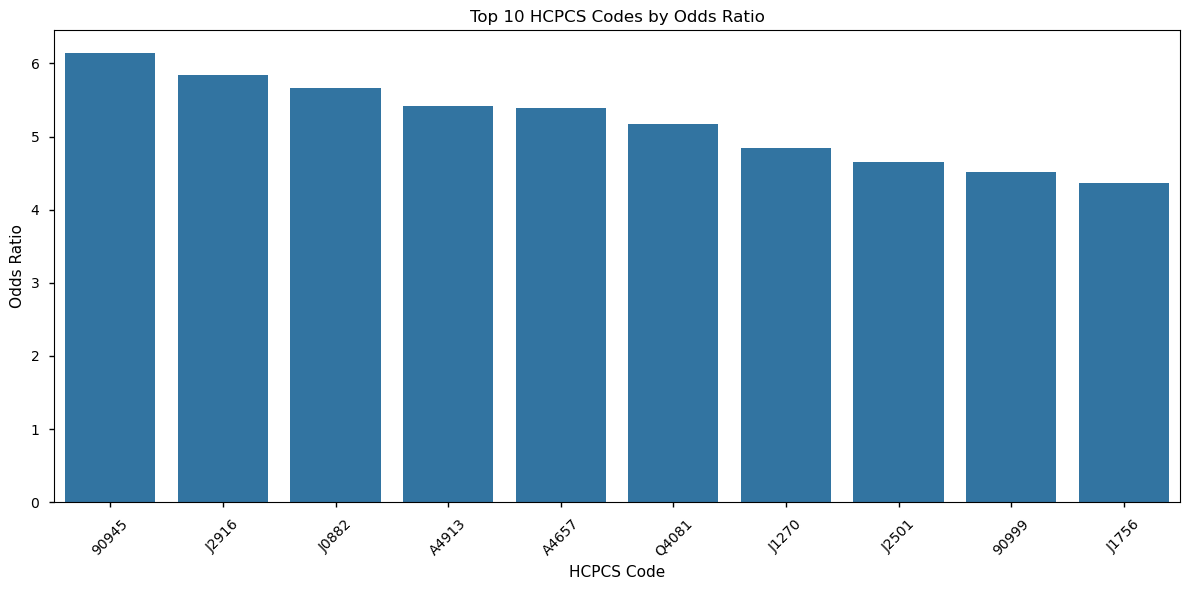

In [199]:
# Step 2: Explode to one row per ICD code per claim
claims_exploded = claims_window[['DESYNPUF_ID', 'septicemia_case_ind', 'hcpcs_list']].explode('hcpcs_list').rename(columns={'hcpcs_list': 'HCPCS_code'})
claims_exploded = claims_exploded[claims_exploded['HCPCS_code'].notnull()]

# Step 3: Compute prevalence (1 if code present, 0 otherwise)
prevalence = claims_exploded.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code']).size().reset_index().rename(columns={0: 'count'})
prevalence['present'] = (prevalence['count'] > 0).astype('int8')
prevalence = prevalence[['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code', 'present']].drop_duplicates()

# Step 4: Compute 2x2 contingency table for each ICD code
total_beneficiaries = claims_window[['DESYNPUF_ID', 'septicemia_case_ind']].drop_duplicates().groupby('septicemia_case_ind')['DESYNPUF_ID'].nunique()
n_pos = total_beneficiaries[1]
n_neg = total_beneficiaries[0]

odds_ratios = []
for hcpcs_code in prevalence['HCPCS_code'].unique():
    # Subset for current ICD code
    code_data = prevalence[prevalence['HCPCS_code'] == hcpcs_code]
    
    # Count patients with/without code in each group
    pos_with_code = code_data[(code_data['septicemia_case_ind'] == 1) & (code_data['present'] == 1)]['DESYNPUF_ID'].nunique()
    pos_without_code = n_pos - pos_with_code
    neg_with_code = code_data[(code_data['septicemia_case_ind'] == 0) & (code_data['present'] == 1)]['DESYNPUF_ID'].nunique()
    neg_without_code = n_neg - neg_with_code
    
    # Compute prevalence
    prev_pos = pos_with_code / n_pos if n_pos > 0 else 0
    prev_neg = neg_with_code / n_neg if n_neg > 0 else 0
    prev_diff = prev_pos - prev_neg
    prev_ratio = prev_pos / prev_neg if prev_neg > 0 else np.inf
    
    # Compute odds ratio
    if pos_without_code > 0 and neg_with_code > 0:  # Avoid division by zero
        odds_ratio = (pos_with_code * neg_without_code) / (pos_without_code * neg_with_code)
    else:
        odds_ratio = np.inf
    
    # Compute chi-squared test for significance
    contingency_table = [[pos_with_code, pos_without_code], [neg_with_code, neg_without_code]]
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table, correction=True)
    
    odds_ratios.append({
        'HCPCS_code': hcpcs_code,
        'prevalence_positive': prev_pos,
        'prevalence_negative': prev_neg,
        'prevalence_difference': prev_diff,
        'prevalence_ratio': prev_ratio,
        'odds_ratio': odds_ratio,
        'p_value': p_value,
        'pos_with_code': pos_with_code,
        'neg_with_code': neg_with_code
    })

# Convert to DataFrame
odds_ratios_df = pd.DataFrame(odds_ratios)

# Filter significant codes
# Positive-class features: odds_ratio > 2, prevalence_difference > 0.01, p_value < 0.05
positive_codes = odds_ratios_df[
    (odds_ratios_df['odds_ratio'] > 2) &
    (odds_ratios_df['prevalence_difference'] > 0.01) &
    (odds_ratios_df['p_value'] < 0.05)
].sort_values('odds_ratio', ascending=False)

# Negative-class features: odds_ratio < 0.5, prevalence_difference < -0.01, p_value < 0.05
negative_codes = odds_ratios_df[
    (odds_ratios_df['odds_ratio'] < 0.5) &
    (odds_ratios_df['prevalence_difference'] < -0.01) &
    (odds_ratios_df['p_value'] < 0.05)
].sort_values('odds_ratio', ascending=True)

# Combine positive and negative codes
significant_codes = pd.concat([positive_codes, negative_codes]).sort_values('odds_ratio', ascending=False)

# Save results
output_path = '/home/jim/git/healthcare-synpuf-pipeline/outputs/eda/hcpcs_odds_ratios.csv'
significant_codes.to_csv(output_path, index=False)
# logger.info(f"Saved odds ratios to {output_path}")

# Visualize top 10 codes
top_10_codes = significant_codes.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_10_codes, x='HCPCS_code', y='odds_ratio')
plt.title('Top 10 HCPCS Codes by Odds Ratio')
plt.xlabel('HCPCS Code')
plt.ylabel('Odds Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/home/jim/git/healthcare-synpuf-pipeline/outputs/eda/top_hcpcs_odds_ratios.png')
plt.show()

In [200]:
significant_codes['HCPCS_code'].tolist()

['90945',
 'J2916',
 'J0882',
 'A4913',
 'A4657',
 'Q4081',
 'J1270',
 'J2501',
 '90999',
 'J1756',
 '80162',
 '93307',
 '82310',
 '99291',
 'J2405',
 'A0425',
 '83970',
 '98941',
 '92135']

## Beneficiary Demographics
Analyze age, sex, and chronic conditions.

In [69]:
# Age distribution
age_stats = beneficiary_df['age'].describe().compute()
logger.info(f'Age statistics: {age_stats}')

plt.figure(figsize=(10, 6))
sns.histplot(beneficiary_df['age'].compute(), bins=30, kde=True)
plt.title('Age Distribution of Beneficiaries')
plt.xlabel('Age')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'age_distribution.png'))
plt.close()

# Sex distribution
sex_counts = beneficiary_df['BENE_SEX_IDENT_CD'].value_counts().compute()
logger.info(f'Sex distribution: {sex_counts}')

plt.figure(figsize=(6, 6))
sex_counts.plot(kind='bar')
plt.title('Sex Distribution')
plt.xlabel('Sex (1=Male, 2=Female)')
plt.ylabel('Count')
plt.savefig(os.path.join(output_dir, 'sex_distribution.png'))
plt.close()

# Chronic condition prevalence
chronic_prevalence = beneficiary_df[chronic_cols].mean().compute() * 100
logger.info(f'Chronic condition prevalence (%): {chronic_prevalence}')

plt.figure(figsize=(12, 6))
chronic_prevalence.sort_values(ascending=False).plot(kind='bar')
plt.title('Chronic Condition Prevalence')
plt.xlabel('Condition')
plt.ylabel('Prevalence (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'chronic_condition_prevalence.png'))
plt.close()

SynPUFPipeline - INFO - Age statistics: count    114538.000000
mean         72.629983
std          12.534732
min          26.000000
25%          67.000000
50%          73.000000
75%          81.000000
max         100.000000
Name: age, dtype: float64
SynPUFPipeline - INFO - Sex distribution: BENE_SEX_IDENT_CD
1    51194
2    63344
Name: count, dtype: int64[pyarrow]
SynPUFPipeline - INFO - Chronic condition prevalence (%): SP_ALZHDMTA    23.052611
SP_CHF         34.432241
SP_CHRNKIDN    20.707538
SP_CNCR         8.151007
SP_COPD        15.649828
SP_DEPRESSN    24.520247
SP_DIABETES    41.653425
SP_ISCHMCHT    47.670642
SP_OSTEOPRS    19.127277
SP_RA_OA       17.456215
SP_STRKETIA     5.264628
dtype: float64


In [ ]:
# split by septicemia status

## Claims Analysis
Analyze claim counts, payment amounts, and top ICD-9/HCPCS codes.

SynPUFPipeline - INFO - Computing average claim counts per beneficiary by file type and cohort
SynPUFPipeline - INFO - Average claim counts by file type and cohort:    septicemia_case_ind   file_type  claim_count
0                  0.0     carrier     2.481963
1                  0.0   inpatient     1.054181
2                  0.0  outpatient     1.246565
3                  1.0     carrier     3.074830
4                  1.0   inpatient     1.045045
5                  1.0  outpatient     1.337838


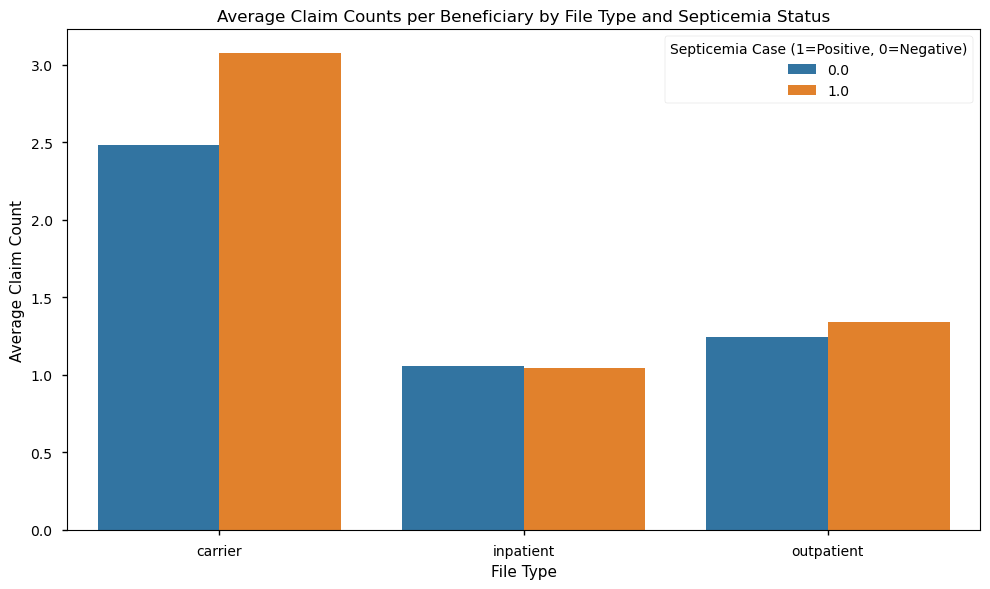

In [165]:
# 1. Average Claim Counts by File Type and Cohort
logger.info("Computing average claim counts per beneficiary by file type and cohort")
claim_counts_per_bene = claims_window.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'file_type'])['CLM_ID'].count().reset_index().rename(columns={'CLM_ID': 'claim_count'})
average_claims = claim_counts_per_bene.groupby(['septicemia_case_ind', 'file_type'])['claim_count'].mean().reset_index()
logger.info(f'Average claim counts by file type and cohort: {average_claims}')

plt.figure(figsize=(10, 6))
sns.barplot(data=average_claims, x='file_type', y='claim_count', hue='septicemia_case_ind')
plt.title('Average Claim Counts per Beneficiary by File Type and Septicemia Status')
plt.xlabel('File Type')
plt.ylabel('Average Claim Count')
plt.legend(title='Septicemia Case (1=Positive, 0=Negative)')
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Computing average spend per beneficiary by file type and cohort
SynPUFPipeline - INFO - Average spend by file type and cohort:    septicemia_case_ind   file_type   total_spend
0                  0.0     carrier    220.287411
1                  0.0   inpatient  10313.398115
2                  0.0  outpatient    339.188714
3                  1.0     carrier    297.777778
4                  1.0   inpatient  11225.225225
5                  1.0  outpatient    511.729730


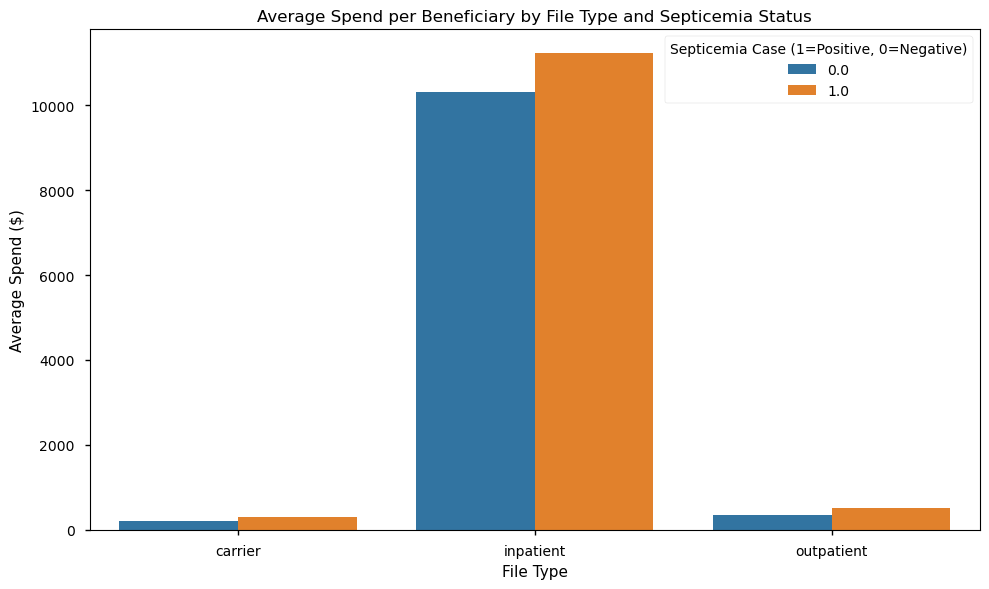

In [167]:
# 2. Average Spend by File Type and Cohort
logger.info("Computing average spend per beneficiary by file type and cohort")
spend_per_bene = claims_window.groupby(['DESYNPUF_ID', 'septicemia_case_ind', 'file_type'])['CLM_PMT_AMT'].sum().reset_index().rename(columns={'CLM_PMT_AMT': 'total_spend'})
average_spend = spend_per_bene.groupby(['septicemia_case_ind', 'file_type'])['total_spend'].mean().reset_index()
logger.info(f'Average spend by file type and cohort: {average_spend}')

plt.figure(figsize=(10, 6))
sns.barplot(data=average_spend, x='file_type', y='total_spend', hue='septicemia_case_ind')
plt.title('Average Spend per Beneficiary by File Type and Septicemia Status')
plt.xlabel('File Type')
plt.ylabel('Average Spend ($)')
plt.legend(title='Septicemia Case (1=Positive, 0=Negative)')
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Analyzing top ICD-9 codes by prevalence difference


<Figure size 1200x600 with 0 Axes>

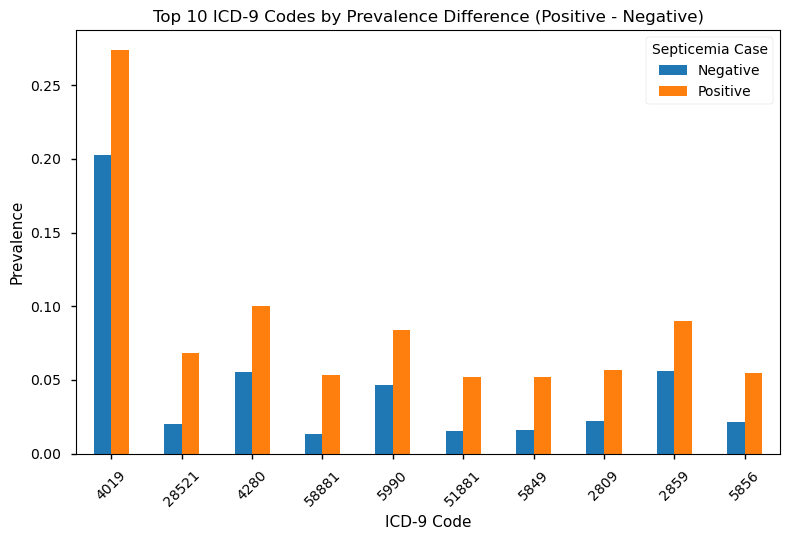

In [170]:
# 3. Top ICD-9 Codes by Prevalence Difference
logger.info("Analyzing top ICD-9 codes by prevalence difference")
icd9_cols = [col for col in claims_window.columns if 'ICD9_DGNS_CD' in col or 'LINE_ICD9_DGNS_CD' in col]
icd_melted = claims_window[['DESYNPUF_ID', 'septicemia_case_ind'] + icd9_cols].melt(
    id_vars=['DESYNPUF_ID', 'septicemia_case_ind'], 
    value_vars=icd9_cols, 
    value_name='ICD_code'
)
icd_melted = icd_melted[icd_melted['ICD_code'].notnull() & (icd_melted['ICD_code'] != '') & (icd_melted['ICD_code'] != 'None')]
icd_unique = icd_melted[['DESYNPUF_ID', 'septicemia_case_ind', 'ICD_code']].drop_duplicates()

# Compute prevalence
code_counts = icd_unique.groupby(['septicemia_case_ind', 'ICD_code'])['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'n_beneficiaries'})
total_beneficiaries = claims_window[['DESYNPUF_ID', 'septicemia_case_ind']].drop_duplicates().groupby('septicemia_case_ind')['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'total_beneficiaries'})
code_counts = code_counts.merge(total_beneficiaries, on='septicemia_case_ind')
code_counts['prevalence'] = code_counts['n_beneficiaries'] / code_counts['total_beneficiaries']

# Pivot and find top differences
prevalence_pivot = code_counts.pivot_table(index='ICD_code', columns='septicemia_case_ind', values='prevalence').fillna(0)
prevalence_pivot['difference'] = prevalence_pivot[1] - prevalence_pivot[0]
top_icd9 = prevalence_pivot.sort_values('difference', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_icd9[[0, 1]].rename(columns={0: 'Negative', 1: 'Positive'}).plot(kind='bar')
plt.title('Top 10 ICD-9 Codes by Prevalence Difference (Positive - Negative)')
plt.xlabel('ICD-9 Code')
plt.ylabel('Prevalence')
plt.legend(title='Septicemia Case')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

SynPUFPipeline - INFO - Analyzing top HCPCS codes by prevalence difference


<Figure size 1200x600 with 0 Axes>

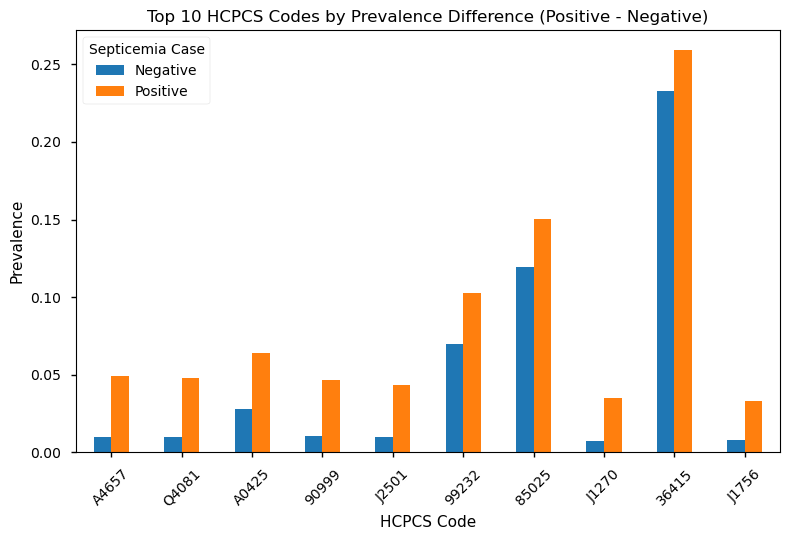

In [174]:
# 4. Top HCPCS Codes by Prevalence Difference
logger.info("Analyzing top HCPCS codes by prevalence difference")
hcpcs_cols = [col for col in claims_window.columns if 'HCPCS_CD' in col]
hcpcs_melted = claims_window[['DESYNPUF_ID', 'septicemia_case_ind'] + hcpcs_cols].melt(
    id_vars=['DESYNPUF_ID', 'septicemia_case_ind'], 
    value_vars=hcpcs_cols, 
    value_name='HCPCS_code'
)
hcpcs_melted = hcpcs_melted[hcpcs_melted['HCPCS_code'].notnull() & (hcpcs_melted['HCPCS_code'] != '') & (hcpcs_melted['HCPCS_code'] != 'nan')]
hcpcs_unique = hcpcs_melted[['DESYNPUF_ID', 'septicemia_case_ind', 'HCPCS_code']].drop_duplicates()

# Compute prevalence
hcpcs_counts = hcpcs_unique.groupby(['septicemia_case_ind', 'HCPCS_code'])['DESYNPUF_ID'].nunique().reset_index().rename(columns={'DESYNPUF_ID': 'n_beneficiaries'})
hcpcs_counts = hcpcs_counts.merge(total_beneficiaries, on='septicemia_case_ind')
hcpcs_counts['prevalence'] = hcpcs_counts['n_beneficiaries'] / hcpcs_counts['total_beneficiaries']

# Pivot and find top differences
hcpcs_pivot = hcpcs_counts.pivot_table(index='HCPCS_code', columns='septicemia_case_ind', values='prevalence').fillna(0)
hcpcs_pivot['difference'] = hcpcs_pivot[1] - hcpcs_pivot[0]
top_hcpcs = hcpcs_pivot.sort_values('difference', ascending=False).head(10)

plt.figure(figsize=(12, 6))
top_hcpcs[[0, 1]].rename(columns={0: 'Negative', 1: 'Positive'}).plot(kind='bar')
plt.title('Top 10 HCPCS Codes by Prevalence Difference (Positive - Negative)')
plt.xlabel('HCPCS Code')
plt.ylabel('Prevalence')
plt.legend(title='Septicemia Case')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## ICD9 Co-occurance for interaction features

In [3]:
# Load dataset
dataset = pd.read_csv(os.path.join(project_root, 'data/processed/septicemia_risk/dataset.csv'))

# Filter to positive septicemia class
positive_df = dataset[dataset['septicemia_case_ind'] == 1]

# Identify ICD-9 binary flag columns (e.g., icd9_40390_30d)
icd_cols = [col for col in positive_df.columns if 'icd9_' in col]
logger.info(f"Number of ICD-9 flag columns: {len(icd_cols)}")

SynPUFPipeline - INFO - Number of ICD-9 flag columns: 34


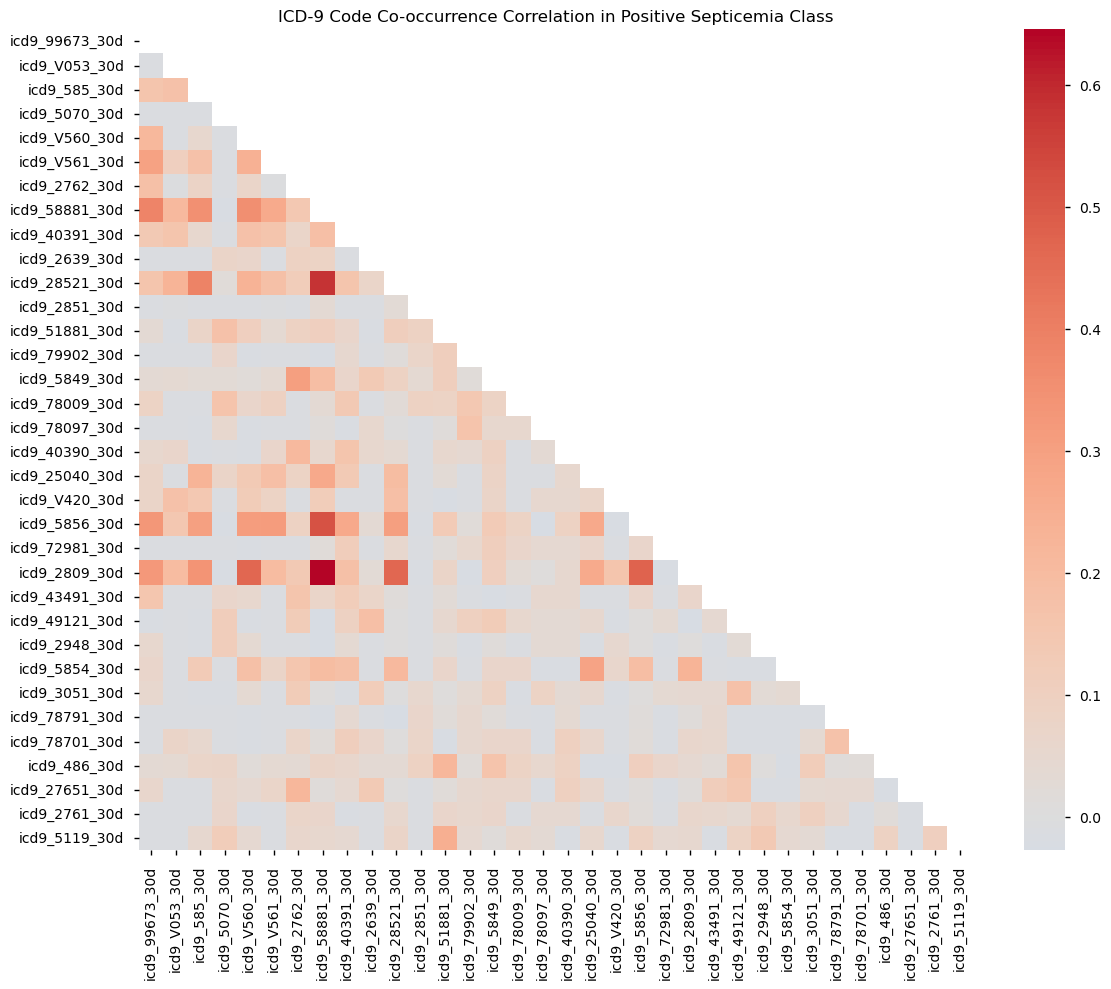

In [4]:
# Step 1: Compute correlation matrix for ICD-9 flags
corr_matrix = positive_df[icd_cols].corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, annot=False)
plt.title('ICD-9 Code Co-occurrence Correlation in Positive Septicemia Class')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'icd9_cooccurrence_heatmap.png'))
plt.show()

In [5]:
# Extract top correlated pairs
corr_pairs = corr_matrix.unstack().reset_index()
corr_pairs.columns = ['code1', 'code2', 'correlation']
corr_pairs = corr_pairs[corr_pairs['code1'] != corr_pairs['code2']]  # Remove self-pairs
top_corr_pairs = corr_pairs.sort_values('correlation', ascending=False).head(20)
logger.info(f"Top 20 correlated ICD-9 pairs in positive class:\n{top_corr_pairs}")
top_corr_pairs.to_csv(os.path.join(output_dir, 'top_icd9_corr_pairs.csv'), index=False)

SynPUFPipeline - INFO - Top 20 correlated ICD-9 pairs in positive class:
              code1           code2  correlation
755   icd9_2809_30d  icd9_58881_30d     0.645584
260  icd9_58881_30d   icd9_2809_30d     0.645584
347  icd9_28521_30d  icd9_58881_30d     0.583483
248  icd9_58881_30d  icd9_28521_30d     0.583483
687   icd9_5856_30d  icd9_58881_30d     0.516486
258  icd9_58881_30d   icd9_5856_30d     0.516486
702   icd9_5856_30d   icd9_2809_30d     0.474703
768   icd9_2809_30d   icd9_5856_30d     0.474703
758   icd9_2809_30d  icd9_28521_30d     0.469413
362  icd9_28521_30d   icd9_2809_30d     0.469413
752   icd9_2809_30d   icd9_V560_30d     0.469156
158   icd9_V560_30d   icd9_2809_30d     0.469156
78     icd9_585_30d  icd9_28521_30d     0.392546
342  icd9_28521_30d    icd9_585_30d     0.392546
238  icd9_58881_30d  icd9_99673_30d     0.386416
7    icd9_99673_30d  icd9_58881_30d     0.386416
143   icd9_V560_30d  icd9_58881_30d     0.356032
242  icd9_58881_30d   icd9_V560_30d     0.356

In [15]:
from itertools import combinations
from sklearn.metrics import mutual_info_score

# Step 2: Compute co-occurrence frequency for ICD-9 pairs
pair_counts = []
for code1, code2 in list(combinations(icd_cols, 2)):
    count = ((positive_df[code1] == 1) & (positive_df[code2] == 1)).sum()
    pair_counts.append({'code1': code1, 'code2': code2, 'cooccurrence_count': count})

pair_counts_df = pd.DataFrame(pair_counts)
top_pairs = pair_counts_df.sort_values('cooccurrence_count', ascending=False).head(20)
logger.info(f"Top 20 co-occurring ICD-9 pairs in positive class:\n{top_pairs}")
top_pairs.to_csv(os.path.join(output_dir, 'top_icd9_cooccurrence_pairs.csv'), index=False)

SynPUFPipeline - INFO - Top 20 co-occurring ICD-9 pairs in positive class:
              code1           code2  cooccurrence_count
224  icd9_58881_30d   icd9_2809_30d                  25
212  icd9_58881_30d  icd9_28521_30d                  25
296  icd9_28521_30d   icd9_2809_30d                  21
222  icd9_58881_30d   icd9_5856_30d                  20
471   icd9_5856_30d   icd9_2809_30d                  19
294  icd9_28521_30d   icd9_5856_30d                  14
143   icd9_V560_30d   icd9_2809_30d                  12
72     icd9_585_30d  icd9_28521_30d                  10
128   icd9_V560_30d  icd9_58881_30d                   9
347  icd9_51881_30d    icd9_486_30d                   9
69     icd9_585_30d  icd9_58881_30d                   8
141   icd9_V560_30d   icd9_5856_30d                   8
216  icd9_58881_30d   icd9_5849_30d                   8
6    icd9_99673_30d  icd9_58881_30d                   8
84     icd9_585_30d   icd9_2809_30d                   8
247  icd9_40391_30d   icd9_58

In [8]:
# Step 3: Compute mutual information for ICD-9 pairs
mi_pairs = []
for code1, code2 in combinations(icd_cols, 2):
    mi = mutual_info_score(positive_df[code1], positive_df[code2])
    mi_pairs.append({'code1': code1, 'code2': code2, 'mutual_info': mi})

mi_pairs_df = pd.DataFrame(mi_pairs)
top_mi_pairs = mi_pairs_df.sort_values('mutual_info', ascending=False).head(20)
logger.info(f"Top 20 ICD-9 pairs by mutual information in positive class:\n{top_mi_pairs}")
top_mi_pairs.to_csv(os.path.join(output_dir, 'top_icd9_mi_pairs.csv'), index=False)

SynPUFPipeline - INFO - Top 20 ICD-9 pairs by mutual information in positive class:
              code1           code2  mutual_info
224  icd9_58881_30d   icd9_2809_30d     0.065311
212  icd9_58881_30d  icd9_28521_30d     0.058854
222  icd9_58881_30d   icd9_5856_30d     0.044684
296  icd9_28521_30d   icd9_2809_30d     0.041590
471   icd9_5856_30d   icd9_2809_30d     0.039590
143   icd9_V560_30d   icd9_2809_30d     0.030649
72     icd9_585_30d  icd9_28521_30d     0.023734
294  icd9_28521_30d   icd9_5856_30d     0.020309
6    icd9_99673_30d  icd9_58881_30d     0.020019
128   icd9_V560_30d  icd9_58881_30d     0.019279
69     icd9_585_30d  icd9_58881_30d     0.018006
84     icd9_585_30d   icd9_2809_30d     0.017574
19   icd9_99673_30d   icd9_5856_30d     0.015804
21   icd9_99673_30d   icd9_2809_30d     0.015621
141   icd9_V560_30d   icd9_5856_30d     0.015604
82     icd9_585_30d   icd9_5856_30d     0.014217
169   icd9_V561_30d   icd9_5856_30d     0.013878
190   icd9_2762_30d   icd9_5849_30

In [9]:
# Optional: Combine top pairs from all methods
combined_pairs = pd.concat([
    top_corr_pairs[['code1', 'code2']].assign(method='correlation'),
    top_pairs[['code1', 'code2']].assign(method='cooccurrence'),
    top_mi_pairs[['code1', 'code2']].assign(method='mutual_info')
]).drop_duplicates(subset=['code1', 'code2'])
combined_pairs.to_csv(os.path.join(output_dir, 'combined_top_icd9_pairs.csv'), index=False)
logger.info(f"Combined top ICD-9 pairs saved to {os.path.join(output_dir, 'combined_top_icd9_pairs.csv')}")

SynPUFPipeline - INFO - Combined top ICD-9 pairs saved to /home/jim/git/healthcare-synpuf-pipeline/data/processed/septicemia_risk/eda/combined_top_icd9_pairs.csv


In [17]:
# Define pairs from your query
pairs = list(combinations(icd_cols, 2))

# Compute presence for each pair (1 if both codes present, 0 otherwise)
for code1, code2 in pairs:
    pair_name = f'pair_{code1}_{code2}'
    dataset[pair_name] = ((dataset[code1] == 1) & (dataset[code2] == 1)).astype(int)

/tmp/ipykernel_35241/2460444989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[pair_name] = ((dataset[code1] == 1) & (dataset[code2] == 1)).astype(int)
/tmp/ipykernel_35241/2460444989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[pair_name] = ((dataset[code1] == 1) & (dataset[code2] == 1)).astype(int)
/tmp/ipykernel_35241/2460444989.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

In [20]:
# Compute PPV, OR, Prevalence Difference, and p-value for Each Pair
from scipy.stats import fisher_exact

results = []

for code1, code2 in pairs:
    code1_clean = code1.replace('.', '')
    code2_clean = code2.replace('.', '')
    pair_name = f'pair_{code1_clean}_{code2_clean}'
    pair_presence = dataset[pair_name]
    septicemia = dataset['septicemia_case_ind']
    
    # Contingency table
    tp = ((pair_presence == 1) & (septicemia == 1)).sum()
    fp = ((pair_presence == 1) & (septicemia == 0)).sum()
    fn = ((pair_presence == 0) & (septicemia == 1)).sum()
    tn = ((pair_presence == 0) & (septicemia == 0)).sum()
    
    # PPV
    ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Prevalence in positive vs negative
    prevalence_pos = tp / (tp + fn) if (tp + fn) > 0 else 0
    prevalence_neg = fp / (fp + tn) if (fp + tn) > 0 else 0
    prevalence_diff = prevalence_pos - prevalence_neg
    
    # Odds Ratio
    odds_pos = tp / fn if fn > 0 else np.inf
    odds_neg = fp / tn if tn > 0 else np.inf
    or_value = odds_pos / odds_neg if odds_neg > 0 else np.inf
    
    # p-value (Fisher's exact test for significance, as counts may be small)
    table = [[tp, fp], [fn, tn]]
    _, p_value = fisher_exact(table)
    
    # Mutual Information
    mi = mutual_info_score(pair_presence, septicemia)
    
    results.append({
        'code1': code1,
        'code2': code2,
        'PPV': ppv,
        'prevalence_pos': prevalence_pos,
        'prevalence_neg': prevalence_neg,
        'prevalence_diff': prevalence_diff,
        'odds_ratio': or_value,
        'p_value': p_value,
        'mutual_info': mi
    })

results_df = pd.DataFrame(results)
logger.info(f"Comparison results:\n{results_df}")
results_df.to_csv('icd_pair_comparison.csv', index=False)

SynPUFPipeline - INFO - Comparison results:
              code1          code2       PPV  prevalence_pos  prevalence_neg  \
0    icd9_99673_30d  icd9_V053_30d  0.000000        0.000000        0.000025   
1    icd9_99673_30d   icd9_585_30d  0.250000        0.001864        0.000074   
2    icd9_99673_30d  icd9_5070_30d  0.000000        0.000000        0.000037   
3    icd9_99673_30d  icd9_V560_30d  0.200000        0.002796        0.000148   
4    icd9_99673_30d  icd9_V561_30d  0.250000        0.002796        0.000111   
..              ...            ...       ...             ...             ...   
556    icd9_486_30d  icd9_2761_30d  0.019231        0.000932        0.000628   
557    icd9_486_30d  icd9_5119_30d  0.042857        0.002796        0.000825   
558  icd9_27651_30d  icd9_2761_30d  0.000000        0.000000        0.000418   
559  icd9_27651_30d  icd9_5119_30d  0.000000        0.000000        0.000246   
560   icd9_2761_30d  icd9_5119_30d  0.125000        0.001864        0.000172

In [35]:
results_df[(results_df['p_value']<0.05) 
            & (results_df['PPV']>=0.5)
            & (results_df['odds_ratio']>2)
            # & (results_df['mutual_info']>0.1)
].sort_values(by='code1',ascending=False).head(20)

,code1,code2,PPV,prevalence_pos,prevalence_neg,prevalence_diff,odds_ratio,p_value,mutual_info
127,icd9_V560_30d,icd9_2762_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
148,icd9_V560_30d,icd9_3051_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
48,icd9_V053_30d,icd9_40390_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
61,icd9_V053_30d,icd9_486_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
14,icd9_99673_30d,icd9_78009_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
22,icd9_99673_30d,icd9_43491_30d,0.666667,0.001864,0.000012,0.001852,151.742297,0.000505,0.000082
24,icd9_99673_30d,icd9_2948_30d,1.000000,0.000932,0.000000,0.000932,inf,0.013033,0.000053
395,icd9_78009_30d,icd9_72981_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
68,icd9_585_30d,icd9_2762_30d,0.500000,0.000932,0.000012,0.000920,75.800373,0.025896,0.000036
242,icd9_40391_30d,icd9_78009_30d,0.500000,0.001864,0.000025,0.001839,75.870215,0.001001,0.000072


In [34]:
results_df.sort_values(by='p_value',ascending=True).head(20)

,code1,code2,PPV,prevalence_pos,prevalence_neg,prevalence_diff,odds_ratio,p_value,mutual_info
224,icd9_58881_30d,icd9_2809_30d,0.078125,0.023299,0.003630,0.019669,6.547095,1.580843e-12,0.000302
212,icd9_58881_30d,icd9_28521_30d,0.072464,0.023299,0.003938,0.019361,6.033740,8.190383e-12,0.000282
222,icd9_58881_30d,icd9_5856_30d,0.076046,0.018639,0.002990,0.015649,6.332368,4.214712e-10,0.000235
471,icd9_5856_30d,icd9_2809_30d,0.075099,0.017707,0.002880,0.014828,6.241891,1.411071e-09,0.000221
143,icd9_V560_30d,icd9_2809_30d,0.137931,0.011184,0.000923,0.010261,12.242639,1.636277e-09,0.000221
296,icd9_28521_30d,icd9_2809_30d,0.065421,0.019571,0.003692,0.015879,5.387006,2.365377e-09,0.000214
72,icd9_585_30d,icd9_28521_30d,0.161290,0.009320,0.000640,0.008680,14.691186,7.901619e-09,0.000203
216,icd9_58881_30d,icd9_5849_30d,0.216216,0.007456,0.000357,0.007099,21.040635,2.240413e-08,0.000192
6,icd9_99673_30d,icd9_58881_30d,0.173913,0.007456,0.000468,0.006988,16.055547,1.365151e-07,0.000170
84,icd9_585_30d,icd9_2809_30d,0.160000,0.007456,0.000517,0.006939,14.525732,2.682550e-07,0.000162


In [ ]:
icd9_V560_30d 	icd9_2762_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
148 	icd9_V560_30d 	icd9_3051_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
48 	icd9_V053_30d 	icd9_40390_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
61 	icd9_V053_30d 	icd9_486_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
14 	icd9_99673_30d 	icd9_78009_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
22 	icd9_99673_30d 	icd9_43491_30d 	0.666667 	0.001864 	0.000012 	0.001852 	151.742297 	0.000505 	0.000082
24 	icd9_99673_30d 	icd9_2948_30d 	1.000000 	0.000932 	0.000000 	0.000932 	inf 	0.013033 	0.000053
395 	icd9_78009_30d 	icd9_72981_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
68 	icd9_585_30d 	icd9_2762_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036
242 	icd9_40391_30d 	icd9_78009_30d 	0.500000 	0.001864 	0.000025 	0.001839 	75.870215 	0.001001 	0.000072
193 	icd9_2762_30d 	icd9_40390_30d 	0.500000 	0.002796 	0.000037 	0.002759 	75.940187 	0.000043 	0.000108
199 	icd9_2762_30d 	icd9_43491_30d 	1.000000 	0.001864 	0.000000 	0.001864 	inf 	0.000170 	0.000105
278 	icd9_2639_30d 	icd9_3051_30d 	0.666667 	0.001864 	0.000012 	0.001852 	151.742297 	0.000505 	0.000082
443 	icd9_25040_30d 	icd9_72981_30d 	0.500000 	0.000932 	0.000012 	0.000920 	75.800373 	0.025896 	0.000036

In [36]:
top_interactions = pd.concat([results_df[(results_df['p_value']<0.05) 
            & (results_df['PPV']>=0.5)
            & (results_df['odds_ratio']>2)],
                             results_df.sort_values(by='p_value',ascending=True).head(20)]).drop_duplicates()

In [41]:
top_pairs = []

for code1, code2 in zip(top_interactions['code1'],top_interactions['code2']):
    # Extract clean codes for feature naming (e.g., 99673_and_2948)
    code1_clean = code1.replace('icd9_', '').replace('_30d', '')
    code2_clean = code2.replace('icd9_', '').replace('_30d', '')
    top_pairs.append((code1_clean,code2_clean))

In [42]:
top_pairs

[('99673', '78009'),
 ('99673', '43491'),
 ('99673', '2948'),
 ('V053', '40390'),
 ('V053', '486'),
 ('585', '2762'),
 ('V560', '2762'),
 ('V560', '3051'),
 ('2762', '40390'),
 ('2762', '43491'),
 ('40391', '78009'),
 ('2639', '3051'),
 ('78009', '72981'),
 ('25040', '72981'),
 ('58881', '2809'),
 ('58881', '28521'),
 ('58881', '5856'),
 ('5856', '2809'),
 ('V560', '2809'),
 ('28521', '2809'),
 ('585', '28521'),
 ('58881', '5849'),
 ('99673', '58881'),
 ('585', '2809'),
 ('2762', '5849'),
 ('99673', '2809'),
 ('585', '58881'),
 ('99673', '5856'),
 ('V560', '58881'),
 ('51881', '5119'),
 ('585', '5856'),
 ('28521', '51881'),
 ('28521', '5856'),
 ('40391', '5856')]